### Importation et configuration du notebook

In [1]:
%load_ext autoreload
%autoreload 2


from utils import *

### Les processus ponctuels temporels

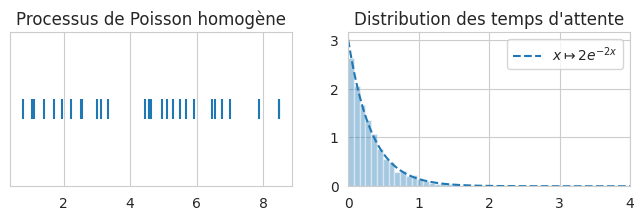

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))

mu = 3
data = poisson(T = 1000, mu=3)

num_samples = 30
axes[0].scatter(data[:num_samples], np.ones(num_samples),
                marker='|', c='C0', s=200)
axes[0].set_yticks([], [])
axes[0].set_title('Processus de Poisson homogène')

diff = np.diff(data, prepend=0)
axes[1].hist(diff, density=True, alpha=0.4, bins=30)
xlim = (0, 4)
axes[1].set_xlim(xlim)
x = np.linspace(0, xlim[-1], 1000)
axes[1].plot(x, mu * np.exp(-mu * x), c='C0', linestyle='--',
             label='$x \\mapsto 2e^{-2x}$')
axes[1].set_title('Distribution des temps d\'attente')

plt.legend()
plt.savefig('../images/poisson_process.png', bbox_inches='tight',
            transparent=True)

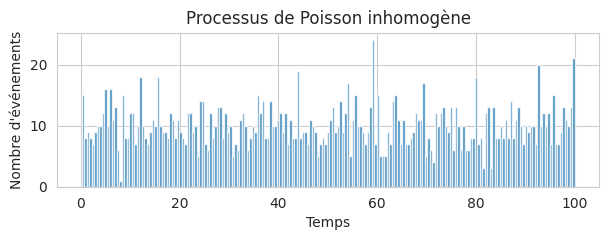

In [ ]:
T = 100
mu = 20
seq = poisson_inh(T, mu)
plt.figure(figsize=(7, 2))
plt.hist(seq, bins=seq.size // 10, alpha=0.8, color='C0')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson inhomogène')
plt.savefig('../images/poisson_inh.png', bbox_inches='tight', transparent=True)

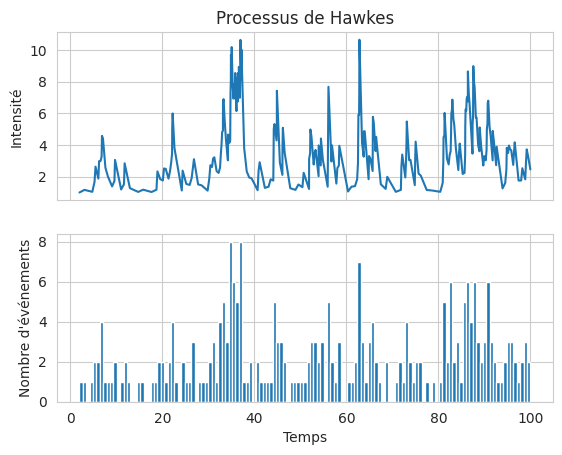

In [ ]:
T = 100
alpha = 1
beta = 2
seq = hawkes(alpha=1, beta=2, T=T)
intensities = [intensity(s, seq) for s in seq]

fig, axes = plt.subplots(2, 1, sharex='col')
axes[0].plot(seq, intensities)
axes[0].set_ylabel('Intensité')
axes[0].set_title('Processus de Hawkes')
axes[1].hist(seq, bins=seq.size // 2)
axes[1].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
plt.savefig('../images/hawkes.png', bbox_inches='tight', transparent=True)

### Le modèle ETAS

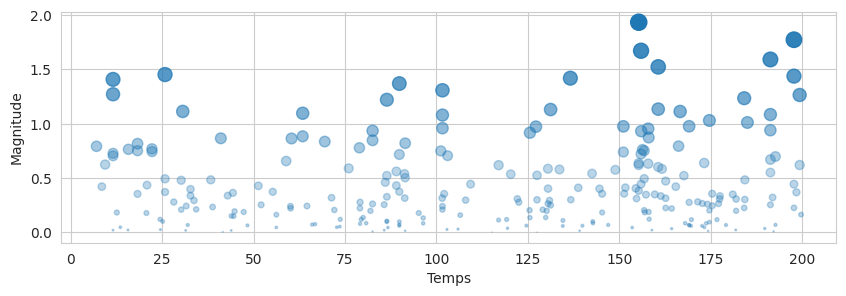

In [3]:
seq = etas(t_end=200)
frame = to_frame(seq)
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(frame.time, frame.magnitude, s=frame.magnitude * 70,
                alpha=np.maximum(.3, frame.magnitude / frame.magnitude.max()))
plt.xlabel('Temps')
plt.ylabel('Magnitude')
plt.savefig('../images/etas_mag.png', bbox_inches='tight', dpi=150)
plt.show()

In [25]:
seq = etas(t_end=3000)
frame = to_frame(seq)
frame.iloc[:10, :2]

,time,magnitude
0,0.639224,1.604289
1,0.639224,0.409295
2,0.639226,0.125361
3,0.639356,0.370638
4,0.639874,0.464503
5,0.639877,0.006245
6,0.649052,0.254912
7,0.748794,0.721520
8,2.600925,0.010425
9,3.530178,0.031414


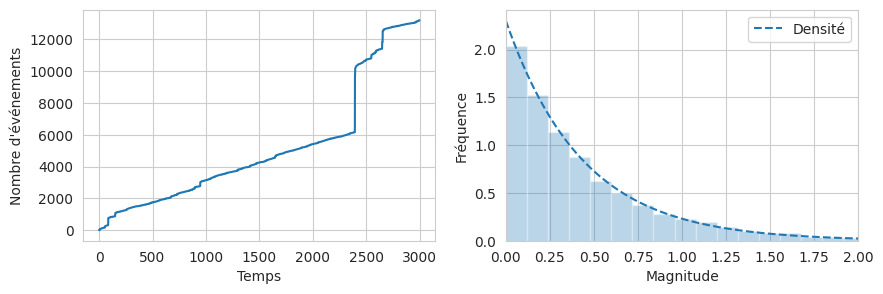

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(frame.time, frame.index + 1)
axes[0].set_xlabel('Temps')
axes[0].set_ylabel('Nombre d\'événements')
axes[1].hist(frame.magnitude, bins=40, density=True, alpha=0.3)
axes[1].set_xlim([0, 2])
x = np.linspace(0, 2, 1000)
y = np.log(10) * np.exp(-np.log(10) * x)
axes[1].plot(x, y, color='C0', label='Densité', linestyle='--')
axes[1].set_xlabel('Magnitude')
axes[1].set_ylabel('Fréquence')
axes[1].legend()
plt.savefig('../images/hist_etas.png', bbox_inches='tight', dpi=150)
plt.show()

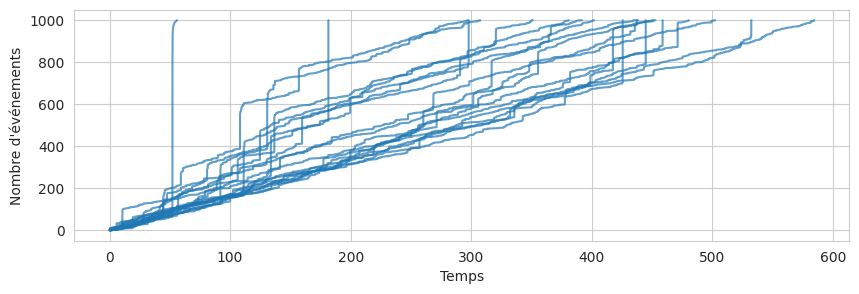

In [27]:
seqs = []
num_seqs = 20
plt.figure(figsize=(10, 3))
for k in range(num_seqs):
    seq = etas(max_len=1000)
    seqs.append(seq)
    plt.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1), c='C0', alpha=0.7)
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.savefig('../images/batch_etas.png', bbox_inches='tight', dpi=150)

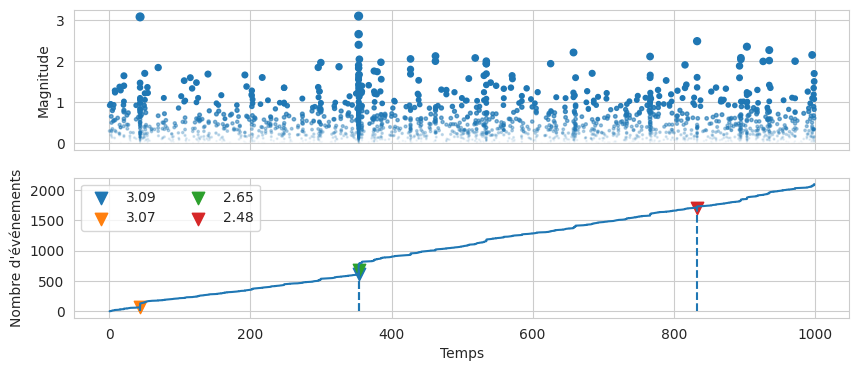

In [ ]:
# On peut visualiser l'influence de la magnitude sur le nombre d'événements.

seq = etas(t_end=1000)
frame = to_frame(seq)
high_mags_idx = frame.magnitude.sort_values(ascending=False).index[:4]
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex='col')
axes[0].scatter(frame.time, frame.magnitude, s=frame.magnitude * 10,
                alpha=np.clip(frame.magnitude, 0, 1))
axes[1].plot(frame.time, frame.index + 1)
for idx in high_mags_idx:
    t = frame.time.iloc[idx]
    m = frame.magnitude.iloc[idx]
    axes[1].vlines(t, 0, idx, cmap=plt.cm.binary, linestyle='--')
    axes[1].scatter(t, idx, s=80, label=round(m, 2), marker='v')
axes[1].set_xlabel('Temps')
axes[0].set_ylabel('Magnitude')
axes[1].set_ylabel('Nombre d\'événements')
axes[1].legend(ncol=2)
plt.savefig('../images/etas_sequence.png', dpi=150, bbox_inches='tight')
plt.show()

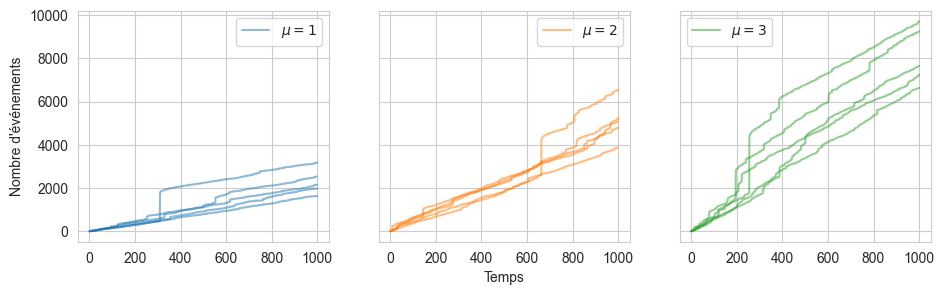

In [35]:
mu = [1, 2, 3]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(11, 3))
for i, (m, ax) in enumerate(zip(mu, axes)):
    for j in range(5):
        label=f'$\\mu = {m}$' if j == 0 else None
        seq = etas(t_end=1000, mu=m, engine='rust')
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1),
                label=label, c=f'C{i}', alpha=0.5)
        ax.legend()
axes[0].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
plt.savefig('../images/mu_etas.png', bbox_inches='tight', dpi=150)

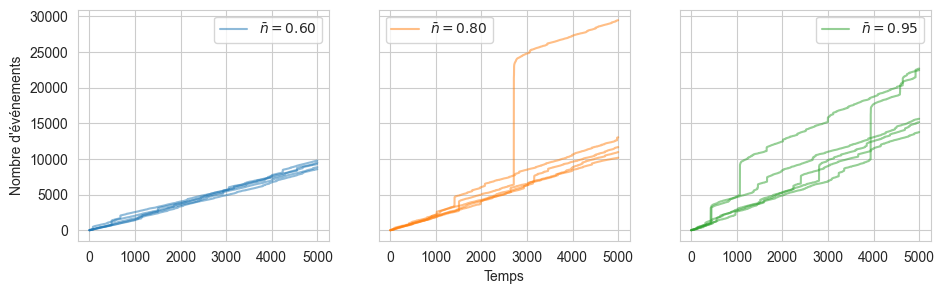

In [32]:
bar_n = [0.6, 0.8, 0.95]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(11, 3))
for i, (b, ax) in enumerate(zip(bar_n, axes)):
    for j in range(5):
        label = f'$\\bar{{n}} = {b:.2f}$' if j == 0 else None
        seq = etas(t_end=5000, bar_n=b, engine='rust')
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1),
                label=label, c=f'C{i}', alpha=0.5)
        ax.legend()
axes[0].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
plt.savefig('../images/bar_n_etas.png', bbox_inches='tight', dpi=150)

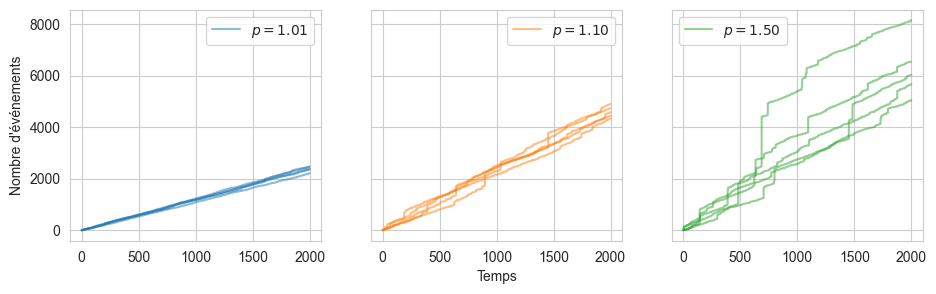

In [33]:
pl = [1.01, 1.1, 1.5]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(11, 3))
for i, (p, ax) in enumerate(zip(pl, axes)):
    for j in range(5):
        label = f'$p = {p:.2f}$' if j == 0 else None
        seq = etas(t_end=2000, p=p, engine='rust')
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1),
                label=label, c=f'C{i}', alpha=0.5)
        ax.legend()

axes[0].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
plt.savefig('../images/p_etas.png', bbox_inches='tight', dpi=150)

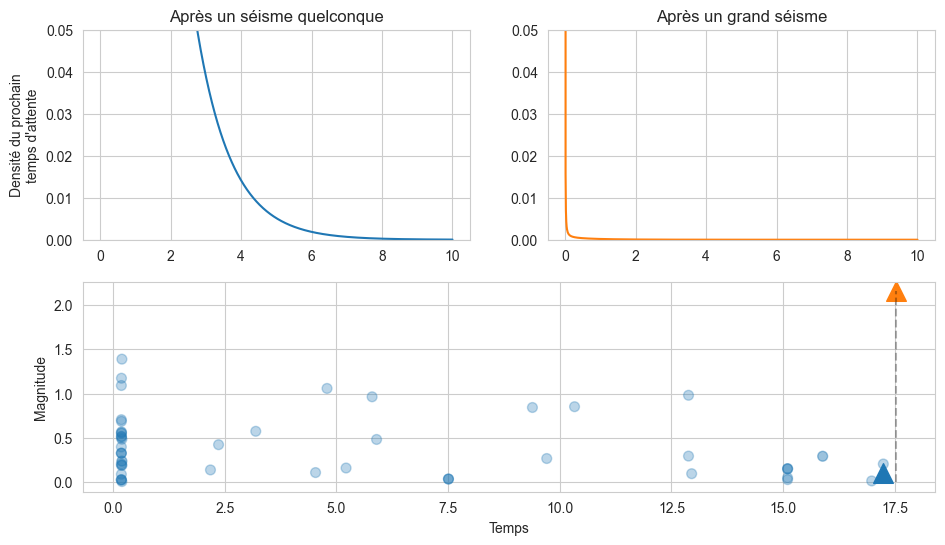

In [27]:
seq = to_frame(etas(t_end=100))
idx = seq.magnitude.sort_values(ascending=False).iloc[:5].sort_index().index
first_mag_idx = idx[0]

fig, axes = plt.subplot_mosaic([['left', 'right'], ['bottom', 'bottom']],
                               figsize=(11, 6))

subset = seq.iloc[:first_mag_idx + 1]
t = subset.time.to_numpy()
m = subset.magnitude.to_numpy()

dist_0 = ETAS(t[:-1], m[:-1])
pdf_0 = dist_0.density
x = np.linspace(0, 10, 1000)
axes['left'].plot(x, pdf_0(x), c='C0')
axes['left'].set_ylim([0, 0.05])
axes['left'].set_ylabel('Densité du prochain\ntemps d\'attente')
axes['left'].set_title('Après un séisme quelconque')

dist_1 = ETAS(t, m)
pdf_1 = dist_1.density
axes['right'].plot(x, pdf_1(x), c='C1')
axes['right'].set_title('Après un grand séisme')

axes['right'].sharex(axes['left'])
axes['right'].sharey(axes['left'])

n_before = 100
size = 50
size_le = size * 4
marker = '^'

axes['bottom'].scatter(t[-n_before:-2], m[-n_before:-2],
                       s=size, alpha=np.maximum(0.3, m[-30:-2] / np.max(m)))
axes['bottom'].vlines(t[-1], 0, m[-1],
                      linestyle='--', colors='black', alpha=0.3)
axes['bottom'].scatter(t[-1], m[-1], c='C1', s=size_le, marker=marker)
axes['bottom'].scatter(t[-2], m[-2], c='C0', s=size_le, marker=marker)
axes['bottom'].set_ylabel('Magnitude')
axes['bottom'].set_xlabel('Temps')

plt.savefig('../images/etas_dist.png', bbox_inches='tight', dpi=150)

### Les réseaux de neurones

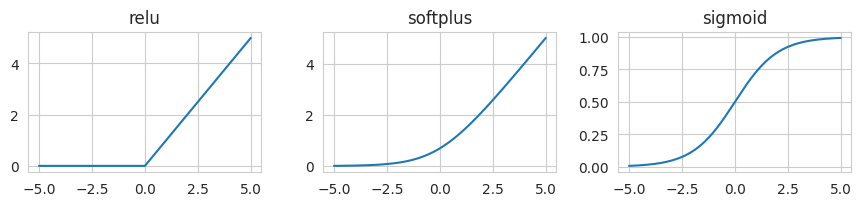

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2))
fig.tight_layout()
x = np.linspace(-5, 5, 1000)
axes[0].plot(x, keras.activations.relu(x))
axes[0].set_title('relu')
axes[1].plot(x, keras.activations.softplus(x))
axes[1].set_title('softplus')
axes[2].plot(x, keras.activations.sigmoid(x))
axes[2].set_title('sigmoid')
plt.savefig('../images/activations.png', bbox_inches='tight', dpi=150)
plt.show()

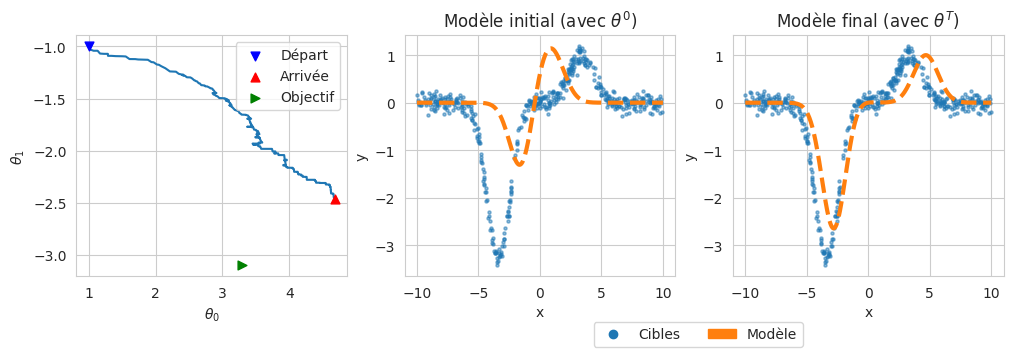

In [218]:
x_train, y_train = data_generation()
thetas = sgd(F, x_train, y_train, theta_0 = jnp.array([1., -1.]),
             lr=0.1, n_step=1000)
plot_sgd(F, x_train, y_train, thetas)
plt.savefig('../images/sgd.png', dpi=200, bbox_inches='tight')

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape, test_images.shape, train_labels.shape)

(60000, 28, 28) (10000, 28, 28) (60000,)


In [7]:
x_train = train_images.astype('float32') / 255
x_test = test_images.astype('float32') / 255

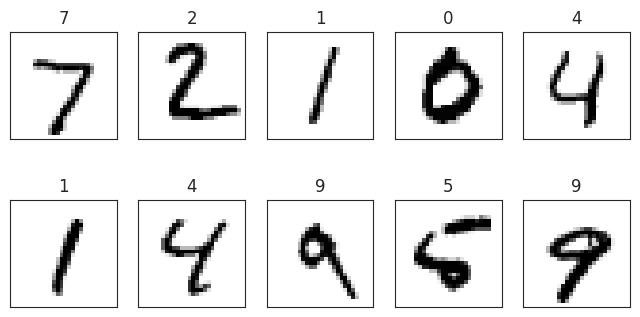

In [8]:
sns.set_style('white')
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(test_images[i], cmap=plt.cm.binary)
    ax.set_title(test_labels[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('../images/mnist.png', bbox_inches='tight', dpi=150)
plt.show()

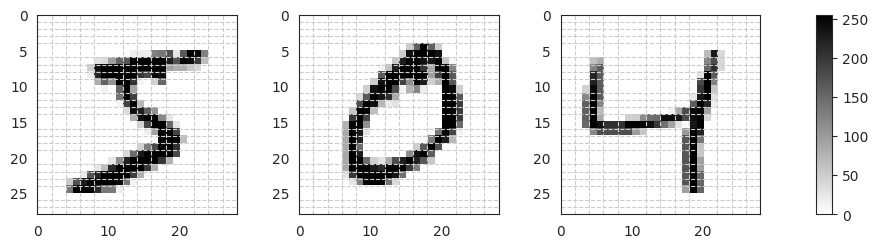

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
fig.tight_layout()
for i, ax in enumerate(axes.ravel()):
    im = ax.imshow(train_images[i], cmap=plt.cm.binary,
                    extent=(0, 28, 28, 0))
    ax.grid(which='minor', linestyle='--')
    ax.minorticks_on()
cax = fig.add_axes([axes[2].get_position().x1 + 0.07,
                    axes[2].get_position().y0,
                    0.02,
                    axes[2].get_position().y1 - axes[2].get_position().y0])
plt.colorbar(im, cax=cax)
plt.savefig('../images/image_encoding.png', bbox_inches='tight', dpi=150)
plt.show()
sns.set_style('whitegrid')

In [10]:
model = keras.Sequential([layers.Flatten(),
                          layers.Dense(512, activation='relu'),
                          layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, train_labels, epochs=15, batch_size=128,
                    validation_data=(x_test, test_labels), verbose=0)

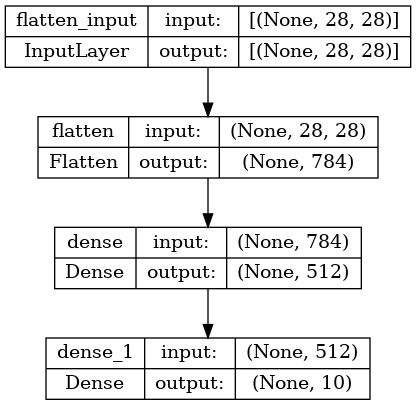

In [11]:
keras.utils.plot_model(model, show_shapes=True, to_file='../images/model.png')

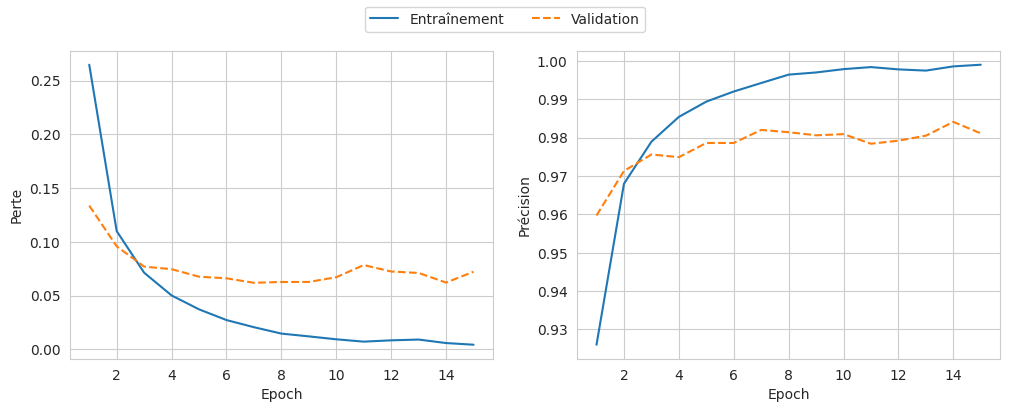

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(epochs, loss, label='Entraînement')
axes[0].plot(epochs, val_loss, label='Validation', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Perte')
axes[1].plot(epochs, accuracy)
axes[1].plot(epochs, val_accuracy, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Précision')
fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/mnist_history.png', bbox_inches='tight', dpi=150)
plt.show()

1/1 [==============================] - 0s 15ms/step


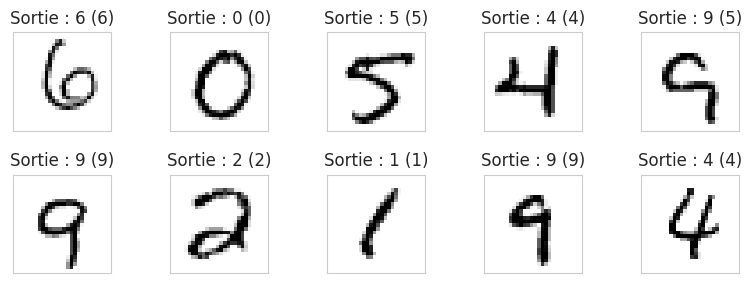

In [36]:
start = 100
end = start + 10
images = x_test[start:end]
labels = test_labels[start:end]
preds = model.predict(images).argmax(1)
fig, axes = plt.subplots(2, (end - start) // 2, figsize=(8, 3))
fig.tight_layout()
images = test_images[start:end]
for ax, im, label, pred in zip(axes.ravel(), images, labels, preds):
    ax.imshow(im, cmap=plt.cm.binary)
    ax.set_title(f'Sortie : {label} ({pred})')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('../images/mnist_preds.png', bbox_inches='tight', dpi=150)

### Application aux processus ponctuels temporels

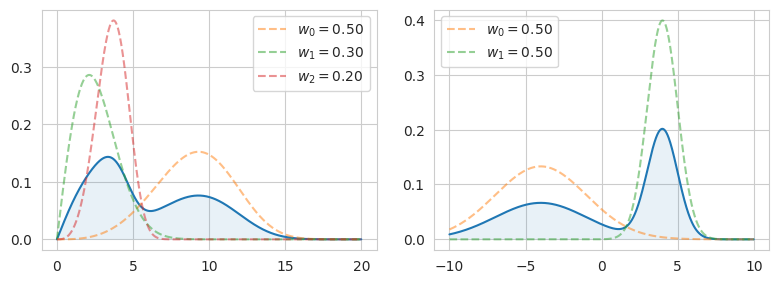

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout()

mix = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.3, 0.2]),
    components_distribution=tfd.Weibull(
        concentration=[4, 2, 4], scale=[10, 3, 4]
    )
)

cp1 = tfd.Weibull(4, 10)
cp2 = tfd.Weibull(2, 3)
cp3 = tfd.Weibull(4, 4)

x = np.linspace(0, 20, 1000)
axes[0].plot(x, mix.prob(x))
for i, d in enumerate([cp1, cp2, cp3]):
    axes[0].plot(x, d.prob(x), alpha=0.5, linestyle='--',
             label=f'$w_{i} = {mix.mixture_distribution.probs[i]:.2f}$')
axes[0].fill_between(x, 0, mix.prob(x), alpha=0.1)
axes[0].legend()

mix = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
    components_distribution=tfd.Normal(
        loc=[-4, 4], scale=[3, 1]
    )
)

cp1 = tfd.Normal(-4, 3)
cp2 = tfd.Normal(4, 1)

x = np.linspace(-10, 10, 1000)
axes[1].plot(x, mix.prob(x))
for i, d in enumerate([cp1, cp2]):
    axes[1].plot(x, d.prob(x), alpha=0.5, linestyle='--',
             label=f'$w_{i} = {mix.mixture_distribution.probs[i]:.2f}$')
axes[1].fill_between(x, 0, mix.prob(x), alpha=0.1)
axes[1].legend()

plt.savefig('../images/mixtures.png', dpi=200, bbox_inches='tight')

In [108]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    batch_size=1, t_end=500
)
print(seqs[0].shape)
etas_log_like = log_likelihood(seqs[0], t_end)
print(etas_log_like)

model = Model(R=10, learning_rate=1e-3, strategy='log_tau')
history = model.fit(inter_times, seq_lengths,
                    t_end, 500, magnitudes, verbose=1)


(1647, 3)
21.847765145916078
Loss at epoch    1:   -8.803
Loss at epoch   10:  -12.584
Loss at epoch   20:  -15.569
Loss at epoch   30:  -17.227
Loss at epoch   40:  -18.213
Loss at epoch   50:  -18.848
Loss at epoch   60:  -19.265
Loss at epoch   70:  -19.507
Loss at epoch   80:  -19.675
Loss at epoch   90:  -19.792
Loss at epoch  100:  -19.881
Loss at epoch  110:  -19.956
Loss at epoch  120:  -20.022
Loss at epoch  130:  -20.081
Loss at epoch  140:  -20.132
Loss at epoch  150:  -20.177
Loss at epoch  160:  -20.217
Loss at epoch  170:  -20.256
Loss at epoch  180:  -20.293
Loss at epoch  190:  -20.329
Loss at epoch  200:  -20.364
Loss at epoch  210:  -20.399
Loss at epoch  220:  -20.433
Loss at epoch  230:  -20.466
Loss at epoch  240:  -20.498
Loss at epoch  250:  -20.529
Loss at epoch  260:  -20.559
Loss at epoch  270:  -20.588
Loss at epoch  280:  -20.616
Loss at epoch  290:  -20.643
Loss at epoch  300:  -20.669
Loss at epoch  310:  -20.694
Loss at epoch  320:  -20.719
Loss at epoch

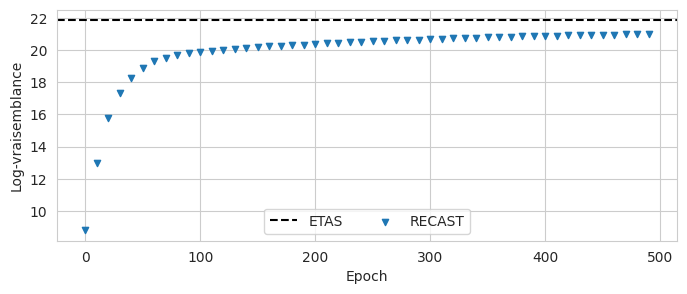

In [109]:
recast_log_like = -np.array(history['loss'])[::10]
x = range(len(recast_log_like))
plt.figure(figsize=(8, 3))
plt.axhline(y=etas_log_like, linestyle='--', c='black', label='ETAS')
plt.scatter(x, recast_log_like, label='RECAST', marker='v', s=20)
plt.legend(ncol=2, loc='lower center')
plt.ylabel('Log-vraisemblance')
plt.xticks(ticks=range(0, 51, 10), labels=range(0, 501, 100))
plt.xlabel('Epoch')
plt.savefig('../images/log_like_cvg.png', bbox_inches='tight', dpi=150)
plt.show()

Loss at epoch    1:    1.671
Loss at epoch   10:    0.349
Loss at epoch   20:    0.117
Loss at epoch   30:    0.123
Loss at epoch   40:    0.107
Loss at epoch   50:    0.100
Loss at epoch   60:    0.099
Loss at epoch   70:    0.098
Loss at epoch   80:    0.097
Loss at epoch   90:    0.096
Loss at epoch  100:    0.095


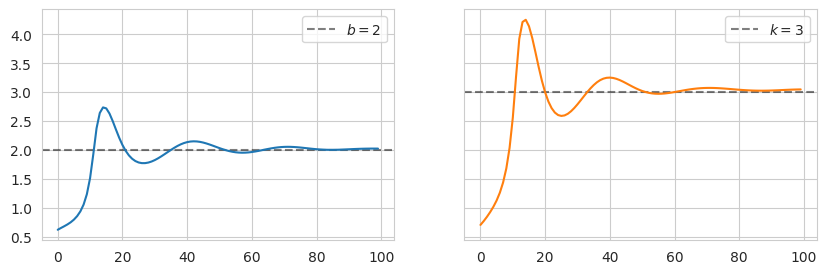

In [6]:
# On entraîne un moèle sur un jeu de données et on 
# récupère les distributions obtenues à chaque epoch (les données
# suivent une loi de Weibull).

b = 2
k = 3
arrival_times = np.cumsum(Weibull(b, k).sample([100, 150]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=100,
                    return_distributions=True, verbose=1)

distributions = history['distributions']
params = [d.params[1] for d in distributions]
params = np.squeeze(np.stack(params, 0), -2)

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(10, 3))

axes[0].axhline(y=b, label=f'$b = {b}$', c='black', linestyle='--', alpha=0.5)
axes[0].legend()
axes[1].axhline(y=k, label=f'$k = {k}$', c='black', linestyle='--', alpha=0.5)
axes[1].legend()

num_epochs = len(distributions)
last_idx = enumerate(seq_lengths)

b_mean_per_epoch = [np.mean(params[i, ..., 0][range(100), seq_lengths])
                    for i in range(num_epochs)]
axes[0].plot(range(num_epochs), b_mean_per_epoch, c='C0')

k_mean_per_epoch = [np.mean(params[i, ..., 1][range(100), seq_lengths])
                      for i in range(num_epochs)]
axes[1].plot(range(num_epochs), k_mean_per_epoch, c='C1')

plt.savefig('../images/weibull_cvg.png', bbox_inches='tight', dpi=150)
plt.show()

Loss at epoch    1:    1.105
Loss at epoch   10:    0.803
Loss at epoch   20:    0.755
Loss at epoch   30:    0.732
Loss at epoch   40:    0.730
Loss at epoch   50:    0.727
Loss at epoch   60:    0.730
Loss at epoch   70:    0.726
Loss at epoch   80:    0.726
Loss at epoch   90:    0.725
Loss at epoch  100:    0.725


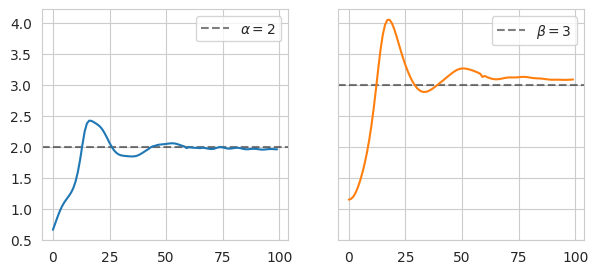

In [ ]:
# On refait la même chose avec des données qui suivent une loi Gamma.

alpha = 2
beta = 3
arrival_times = np.cumsum(tfd.Gamma(alpha, beta).sample([300, 250]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Gamma, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=100,
                    return_distributions=True, verbose=1)

distributions = history['distributions']
params = [d.params[1] for d in distributions]
params = np.squeeze(np.stack(params, 0), -2)

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(7, 3))

axes[0].axhline(y=alpha, label=f'$\\alpha = {alpha}$',
                linestyle='--', c='black', alpha=0.5)
axes[0].legend()
axes[1].axhline(y=beta, label=f'$\\beta = {beta}$',
                linestyle='--', c='black', alpha=0.5)
axes[1].legend()

num_epochs = len(distributions)
last_idx = list(enumerate(seq_lengths))

alpha_mean_per_epoch = [np.mean(params[i, ..., 0][last_idx])
                    for i in range(num_epochs)]
axes[0].plot(range(num_epochs), alpha_mean_per_epoch, c='C0')

beta_mean_per_epoch = [np.mean(params[i, ..., 1][last_idx])
                      for i in range(num_epochs)]
axes[1].plot(range(num_epochs), beta_mean_per_epoch, c='C1')

plt.savefig('../images/gamma_cvg.png', bbox_inches='tight', dpi=150)
plt.show()

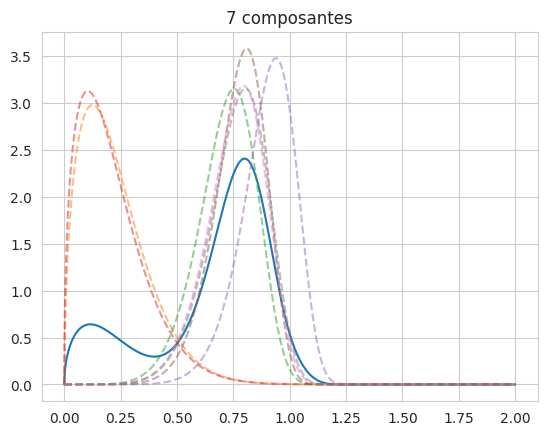

In [75]:
n_comp = np.random.randint(3, 10)
weights = tf.nn.softmax(np.random.uniform(size=n_comp))
b = np.random.uniform(0.5, 9, size=n_comp)
k = np.random.uniform(0.5, 9, size=n_comp)
mix = Mixture(weights, Weibull(b, k))
comps = Weibull(b, k)

x = np.linspace(0, 2, 1000)
plt.plot(x, mix.prob(x))
plt.plot(x, comps.prob(x[..., tf.newaxis]), linestyle='--', alpha=0.5)
plt.title(f'{weights.shape[0]} composantes')
plt.savefig('../images/mixture_weibull.png', bbox_inches='tight')
plt.show()

In [76]:
tau = mix.sample(501)
t = np.cumsum(tau)
t_end = t[-1]
t = t[:-1]

model = Model(32, dist=Weibull, R=10, strategy='tau_log_tau')
history = model.fit([tau], [t.size], t_end, 160, return_distributions=True)

Loss at epoch    1:    1.602
Loss at epoch   10:    0.979
Loss at epoch   20:    0.046
Loss at epoch   30:   -0.136
Loss at epoch   40:   -0.157
Loss at epoch   50:   -0.163
Loss at epoch   60:   -0.169
Loss at epoch   70:   -0.172
Loss at epoch   80:   -0.174
Loss at epoch   90:   -0.177
Loss at epoch  100:   -0.179
Loss at epoch  110:   -0.181
Loss at epoch  120:   -0.183
Loss at epoch  130:   -0.185
Loss at epoch  140:   -0.187
Loss at epoch  150:   -0.189
Loss at epoch  160:   -0.192


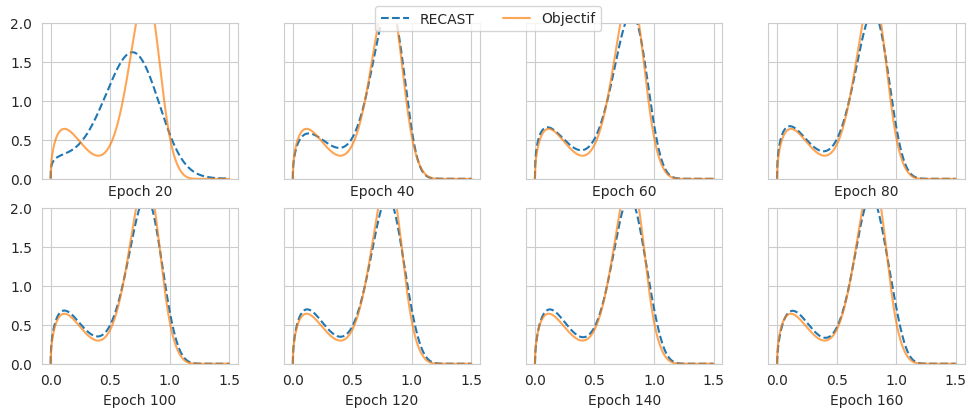

In [77]:
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.tight_layout()
dists = history['distributions']
i = 0
x = np.linspace(0, 1.5, 1000)
for j, ax in enumerate(axes.ravel()):
    i += 20
    recast_dist = get_dist_at_epoch(i - 1, dists)
    label1 = 'RECAST' if j == 1 else None
    label2 = 'Objectif' if j == 1 else None
    ax.plot(x, recast_dist.prob(x), linestyle='--', label=label1)
    ax.plot(x, mix.prob(x), alpha=0.7, label=label2)
    ax.set_xlabel(f'Epoch {i}')
    ax.set_ylim((0, 2))
fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/mix_1.png', bbox_inches='tight', dpi=150)
plt.show()

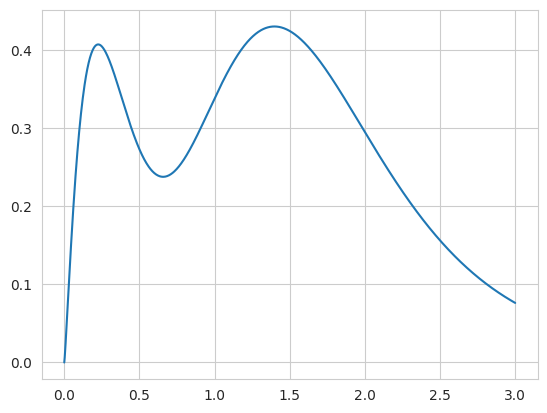

In [34]:
n_comp = np.random.randint(3, 10)
weights = tf.nn.softmax(np.random.uniform(size=n_comp))
b = np.random.uniform(0.5, 9, size=n_comp)
k = np.random.uniform(0.5, 9, size=n_comp)
mix = Mixture(weights, Gamma(b, k))

x = np.linspace(0, 3, 1000)
plt.plot(x, mix.prob(x))
plt.show()

In [35]:
tau = mix.sample(501)
t = np.cumsum(tau, axis=-1)
t_end = t[-1]
t = t[:-1]

model = Model(32, dist=Weibull, R=9, strategy='tau_log_tau')
history = model.fit([tau], [t.size], t_end, 160, return_distributions=True)

Loss at epoch    1:    0.893
Loss at epoch   10:    0.815
Loss at epoch   20:    0.789
Loss at epoch   30:    0.776
Loss at epoch   40:    0.767
Loss at epoch   50:    0.758
Loss at epoch   60:    0.752
Loss at epoch   70:    0.746
Loss at epoch   80:    0.738
Loss at epoch   90:    0.727
Loss at epoch  100:    0.716
Loss at epoch  110:    0.704
Loss at epoch  120:    0.690
Loss at epoch  130:    0.673
Loss at epoch  140:    0.655
Loss at epoch  150:    0.639
Loss at epoch  160:    0.617


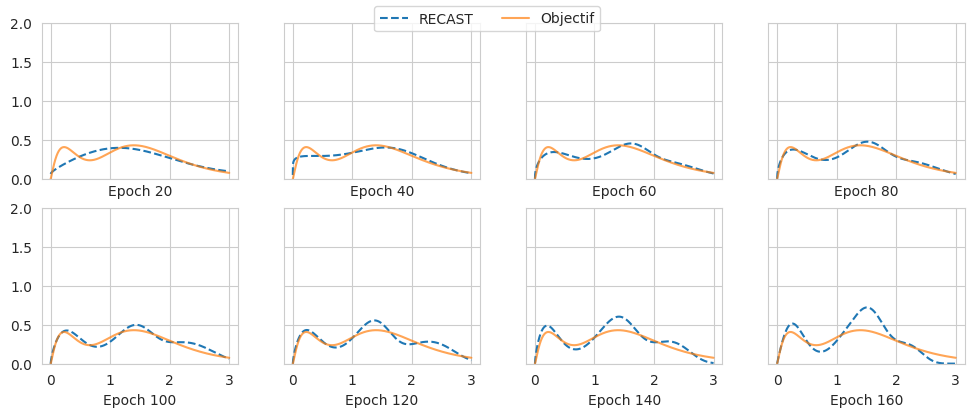

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.tight_layout()
dists = history['distributions']
i = 0
x = np.linspace(0, 3, 1000)
for j, ax in enumerate(axes.ravel()):
    i += 20
    recast_dist = get_dist_at_epoch(i - 1, dists)
    label1 = 'RECAST' if j == 1 else None
    label2 = 'Objectif' if j == 1 else None
    ax.plot(x, recast_dist.prob(x), linestyle='--', label=label1)
    ax.plot(x, mix.prob(x), alpha=0.7, label=label2)
    ax.set_xlabel(f'Epoch {i}')
    ax.set_ylim((0, 2))
fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/mix_2.png', bbox_inches='tight', dpi=150)
plt.show()

Loss at epoch    1:    0.981
Loss at epoch   10:    0.856
Loss at epoch   20:    0.826
Loss at epoch   30:    0.802
Loss at epoch   40:    0.795
Loss at epoch   50:    0.793
Loss at epoch   60:    0.790
Loss at epoch   70:    0.788
Loss at epoch   80:    0.785
Loss at epoch   90:    0.782
Loss at epoch  100:    0.778
Loss at epoch  110:    0.773
Loss at epoch  120:    0.765
Loss at epoch  130:    0.754
Loss at epoch  140:    0.738
Loss at epoch  150:    0.718
Loss at epoch  160:    0.689


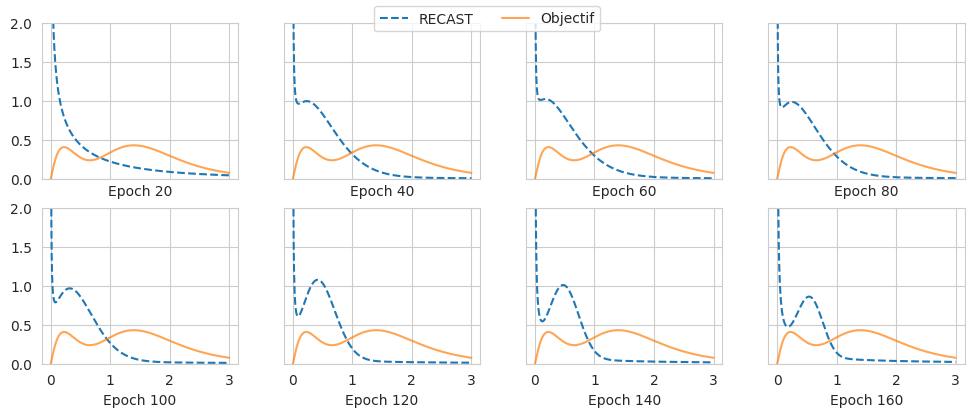

In [42]:
model = Model(32, dist=Gamma, R=2, strategy='tau_log_tau')
history = model.fit([tau], [t.size], t_end, 160, return_distributions=True)

fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.tight_layout()
dists = history['distributions']
i = 0
x = np.linspace(0, 3, 1000)
for j, ax in enumerate(axes.ravel()):
    i += 20
    recast_dist = get_dist_at_epoch(i - 1, dists)
    label1 = 'RECAST' if j == 1 else None
    label2 = 'Objectif' if j == 1 else None
    ax.plot(x, recast_dist.prob(x), linestyle='--', label=label1)
    ax.plot(x, mix.prob(x), alpha=0.7, label=label2)
    ax.set_xlabel(f'Epoch {i}')
    ax.set_ylim((0, 2))
fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/mix_3.png', bbox_inches='tight', dpi=150)
plt.show()

In [170]:
# Le jeu de données est utilisé par Oleksandr Shchur dans son exemple.

with open('../data/shchur.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, 200, verbose=1)
model.save('../models/shchur_1_weibull.pkl')

Loss at epoch    1:    1.221
Loss at epoch   10:    0.820
Loss at epoch   20:    0.815
Loss at epoch   30:    0.808
Loss at epoch   40:    0.798
Loss at epoch   50:    0.792
Loss at epoch   60:    0.786
Loss at epoch   70:    0.781
Loss at epoch   80:    0.776
Loss at epoch   90:    0.772
Loss at epoch  100:    0.767
Loss at epoch  110:    0.763
Loss at epoch  120:    0.755
Loss at epoch  130:    0.738
Loss at epoch  140:    0.746
Loss at epoch  150:    0.737
Loss at epoch  160:    0.730
Loss at epoch  170:    0.726
Loss at epoch  180:    0.723
Loss at epoch  190:    0.737
Loss at epoch  200:    0.736


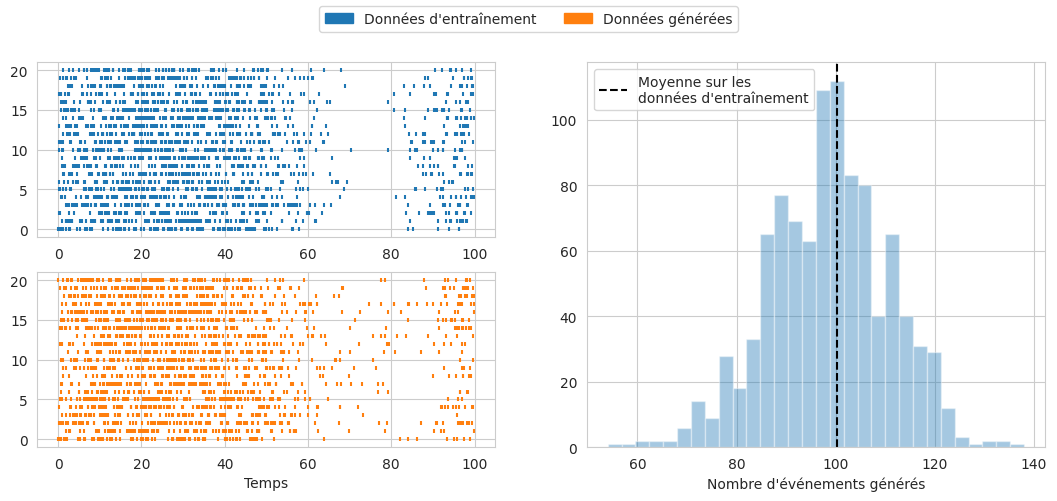

In [169]:
with open('../data/shchur.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
model = Model.load('../models/shchur_1_weibull.pkl')

arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(1000, t_end)

fig, axes = plt.subplot_mosaic([['top', 'right'], ['bottom', 'right']],
                               figsize=(13, 5))
for i, seq in enumerate(arrival_times):
    t = seq[:seq_lengths[i]]
    axes['top'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C0')
    if i == 20:
        break
left_patch = mpatches.Patch(color='C0', label='Données d\'entraînement')

for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes['bottom'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C1')
    if i == 20:
        break
right_patch = mpatches.Patch(color='C1', label='Données générées')

axes['right'].hist(gen_seq_lengths, bins=30, alpha=0.4)
axes['right'].axvline(x=np.mean(seq_lengths), color='black', linestyle='--',
                      label='Moyenne sur les\ndonnées d\'entraînement')
axes['right'].legend(loc='upper left')
axes['top'].sharex(axes['bottom'])
axes['bottom'].set_xlabel('Temps')
axes['right'].set_xlabel('Nombre d\'événements générés')
fig.legend(handles=[left_patch, right_patch], loc='upper center', ncol=2)
plt.savefig('../images/gen_data_1_weibull.png', dpi=150, bbox_inches='tight')

In [14]:
inter_times, seq_lengths, t_end = pickle.load(open('../data/shchur.pkl', 'rb'))
model = Model(C=32, dist=Gamma, R=3)
history = model.fit(inter_times, seq_lengths, t_end, 200, verbose=1)
model.save('../models/shchur_3_gamma.pkl')

Loss at epoch    1:    0.920
Loss at epoch   10:    0.807
Loss at epoch   20:    0.781
Loss at epoch   30:    0.770
Loss at epoch   40:    0.763
Loss at epoch   50:    0.760
Loss at epoch   60:    0.753
Loss at epoch   70:    0.742
Loss at epoch   80:    0.730
Loss at epoch   90:    0.723
Loss at epoch  100:    0.721
Loss at epoch  110:    0.715
Loss at epoch  120:    0.714
Loss at epoch  130:    0.714
Loss at epoch  140:    0.712
Loss at epoch  150:    0.710
Loss at epoch  160:    0.710
Loss at epoch  170:    0.710
Loss at epoch  180:    0.709
Loss at epoch  190:    0.715
Loss at epoch  200:    0.710


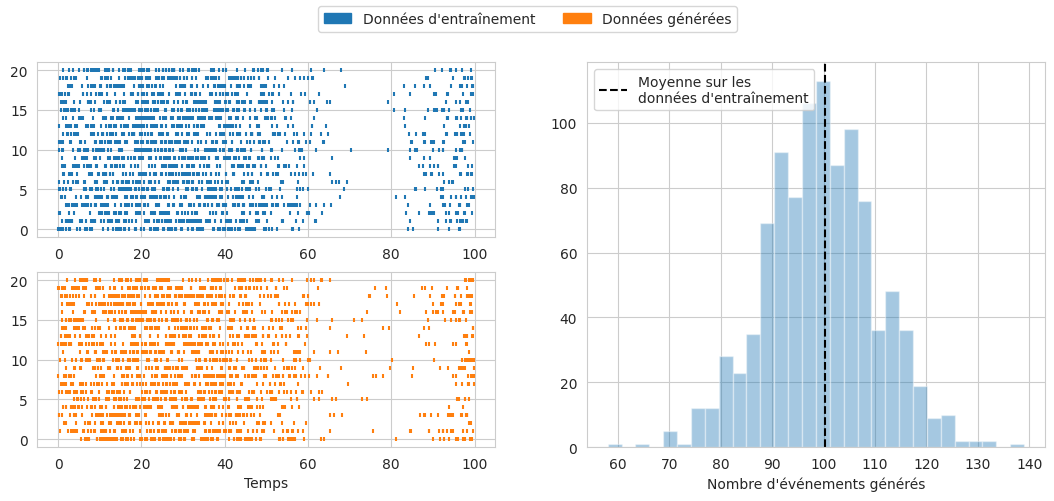

In [168]:
with open('../data/shchur.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
model = Model.load('../models/shchur_3_gamma.pkl')

arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(1000, t_end)

fig, axes = plt.subplot_mosaic([['top', 'right'], ['bottom', 'right']],
                               figsize=(13, 5))
for i, seq in enumerate(arrival_times):
    t = seq[:seq_lengths[i]]
    axes['top'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C0')
    if i == 20:
        break
left_patch = mpatches.Patch(color='C0', label='Données d\'entraînement')

for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes['bottom'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C1')
    if i == 20:
        break
right_patch = mpatches.Patch(color='C1', label='Données générées')

axes['right'].hist(gen_seq_lengths, bins=30, alpha=0.4)
axes['right'].axvline(x=np.mean(seq_lengths), color='black', linestyle='--',
                      label='Moyenne sur les\ndonnées d\'entraînement')
axes['right'].legend(loc='upper left')
axes['top'].sharex(axes['bottom'])
axes['bottom'].set_xlabel('Temps')
axes['right'].set_xlabel('Nombre d\'événements générés')
fig.legend(handles=[left_patch, right_patch], loc='upper center', ncol=2)
plt.savefig('../images/gen_data_3_gamma.png', dpi=150, bbox_inches='tight')

In [89]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    batch_size=100, max_len=250, t_end=100)

model = Model(C=32, dist=Gamma, R=32, dropout_rate=0.5, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 200,
                    magnitudes, verbose=1)


Loss at epoch    1:   -6.572
Loss at epoch   10:   -9.359
Loss at epoch   20:   -9.514
Loss at epoch   30:   -9.610
Loss at epoch   40:   -9.717
Loss at epoch   50:   -9.783
Loss at epoch   60:   -9.850
Loss at epoch   70:   -9.919
Loss at epoch   80:   -9.990
Loss at epoch   90:  -10.039
Loss at epoch  100:  -10.091
Loss at epoch  110:  -10.124
Loss at epoch  120:  -10.154
Loss at epoch  130:  -10.168
Loss at epoch  140:  -10.182
Loss at epoch  150:  -10.195
Loss at epoch  160:  -10.210
Loss at epoch  170:  -10.224
Loss at epoch  180:  -10.240
Loss at epoch  190:  -10.242
Loss at epoch  200:  -10.256


In [131]:
generated_data, seq_lengths = model.generate(20, np.mean(t_end))

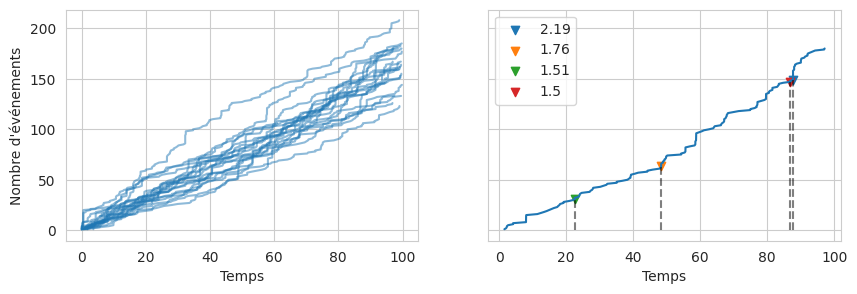

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for i, seq in enumerate(generated_data):
    frame = to_frame(seq).iloc[:seq_lengths[i]]
    axes[0].plot(frame.time, frame.index + 1, color='C0', alpha=0.5)
axes[0].set_xlabel('Temps')
axes[0].set_ylabel('Nombre d\'événements')
i = 9
seq = to_frame(generated_data[i]).iloc[:seq_lengths[i]]
high_mags_idx = seq.magnitude.sort_values(ascending=False).iloc[:4].index
axes[1].plot(seq.time, seq.index + 1)
for idx in high_mags_idx:
    t = seq.time.iloc[idx]
    m = seq.magnitude.iloc[idx]
    axes[1].scatter(t, idx + 1, label=round(m, 2), marker='v')
    axes[1].vlines(t, 0, idx + 1, linestyle='--', color='black', alpha=0.5)
axes[1].legend(loc='upper left')
axes[1].set_xlabel('Temps')
plt.savefig('../images/generated_data.png', bbox_inches='tight', dpi=150)
plt.show()

In [5]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    100, t_end=100, max_len=250, verbose=True)

model = Model(C=32, dist=Weibull, R=3, dropout_rate=.4, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 200, magnitudes)

Generating sequences: 100/100
Loss at epoch    1:   -3.562
Loss at epoch   10:   -8.207
Loss at epoch   20:   -8.634
Loss at epoch   30:   -8.850
Loss at epoch   40:   -8.997
Loss at epoch   50:   -9.117
Loss at epoch   60:   -9.196
Loss at epoch   70:   -9.279
Loss at epoch   80:   -9.336
Loss at epoch   90:   -9.394
Loss at epoch  100:   -9.437
Loss at epoch  110:   -9.488
Loss at epoch  120:   -9.523
Loss at epoch  130:   -9.568
Loss at epoch  140:   -9.614
Loss at epoch  150:   -9.651
Loss at epoch  160:   -9.690
Loss at epoch  170:   -9.719
Loss at epoch  180:   -9.747
Loss at epoch  190:   -9.780
Loss at epoch  200:   -9.803


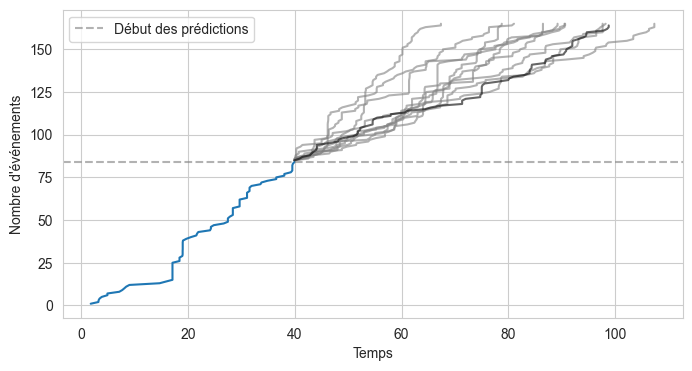

In [6]:
seq = etas(t_end=np.mean(t_end))

n_before = 80
n_preds = 80

past_seq = seq[:-n_before]

fig, ax = plt.subplots(figsize=(8, 4))

t = past_seq[:, 0]
m = past_seq[:, 1]
for i in range(10):
    preds = model.predict(t, m, n_preds)
    t_preds = np.concatenate([[t[-1]], preds[:, 0]])
    m_preds = preds[:, 1]
    ax.plot(t_preds, t.size + cumsum(t_preds), c='gray', alpha=0.6)

seq_size = seq.shape[0]
last_idx_target = min(seq_size - 1, seq_size - n_before + n_preds)
t_targets = seq[-n_before - 1:last_idx_target, 0]

ax.plot(t, cumsum(t))
ax.plot(t_targets, t.size + cumsum(t_targets), alpha=0.6, c='black')
ax.axhline(y=t.size, linestyle='--', c='gray',
           alpha=0.6, label='Début des prédictions')
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Nombre d\'événements')
plt.savefig('../images/etas_preds.png', bbox_inches='tight', dpi=150)

In [7]:
idx = to_frame(seq).magnitude.sort_values(ascending=False).iloc[:10].index
idx

Index([16, 32, 141, 104, 127, 66, 133, 161, 150, 122], dtype='int64')

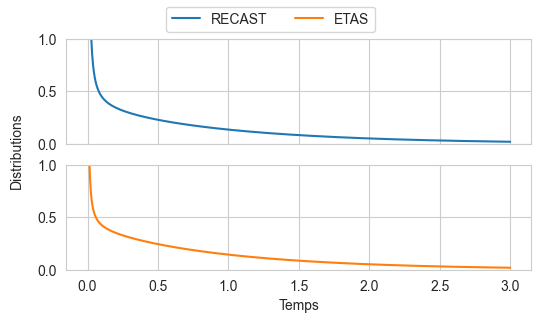

In [8]:
sub_seq = seq[:idx[0]]
t = sub_seq[:, 0]
m = sub_seq[:, 1]

recast_dist = model.predict(t, m, 1, True)[1][0]
etas_dist = ETAS(t, m)

fig, axes = plt.subplots(2, 1, sharex='col', sharey='col', figsize=(6, 3))
x = np.linspace(0, 3, 1000)
axes[0].plot(x, recast_dist.prob(x), label='RECAST')
axes[1].plot(x, etas_dist.prob(x), label='ETAS', c='C1')
axes[1].set_ylim((0, 1))
axes[1].set_xlabel('Temps')
plt.text(-0.55, 0.8, 'Distributions', rotation=90.)
fig.legend(loc='upper center', ncol=2)

plt.savefig('../images/dist_etas_recast_1.png', dpi=150, bbox_inches='tight')

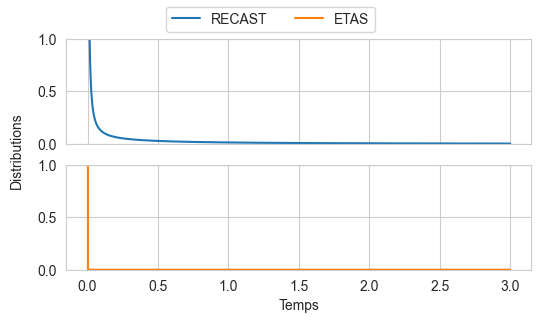

In [9]:
sub_seq = seq[:idx[0] + 1]
t = sub_seq[:, 0]
m = sub_seq[:, 1]

recast_dist = model.predict(t, m, 1, True)[1][0]
etas_dist = ETAS(t, m)

fig, axes = plt.subplots(2, 1, sharex='col', sharey='col', figsize=(6, 3))
x = np.linspace(0, 3, 1000)
axes[0].plot(x, recast_dist.prob(x), label='RECAST')
axes[1].plot(x, etas_dist.prob(x), label='ETAS', c='C1')
axes[1].set_ylim((0, 1))
axes[1].set_xlabel('Temps')
plt.text(-0.55, 0.8, 'Distributions', rotation=90.)
fig.legend(loc='upper center', ncol=2)

plt.savefig('../images/dist_etas_recast_2.png', dpi=150, bbox_inches='tight')